## Task 1: Credit Card Routing for Online Purchase via Predictive Modelling

### Problem statement
* Over the past year, the online payment department at a large retail company have encountered a high failure rate of online credit card payments done via so-called payment service providers, referred to as PSP's by the business stakeholders.
* The company losses alot of money due to failed transactions and customers have become increasingly unsatisfied with the online shop.
* The current routing logic is manual and rule-based. Business decision makers hope that with predictive modelling, a smarter way of routing a PSP to a transaction is possible.

### Data Science Task
* Help the business to automate the credit card routing via a predictive model
* Such a model should increase the payment success rate by finding the best possible PSP for each transaction and at the same time keep the transaction fees low.

# PART 4: Model Selection - Review XGBoost Model
* Based on the analysis done of the model performance, the XGBoost model has been chosen for the further processing

### Import Key Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook 
from bokeh.palettes import Spectral
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show

### Read Dataset and update index

In [3]:
dataset = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

In [4]:
dataset.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [5]:
dataset = dataset.drop('Unnamed: 0', axis=1)

#### Remove Duplicates
* Comment out to include all transactions

In [6]:
dataset.sort_values(["tmsp", "country", "amount"], axis = 0, ascending = True, inplace = True, na_position = "first")
dataset.reset_index(inplace=True, drop=True)
dataset["time_delta"] = (dataset["tmsp"]-dataset["tmsp"].shift(1)).dt.total_seconds()
dataset["time_delta"] = dataset["time_delta"].fillna(0)
same_tx = (dataset["time_delta"]>60).cumsum()
dataset['tx_number'] = dataset.groupby(same_tx).ngroup()
## Comment out to include duplicates
dataset.drop_duplicates(subset=['tx_number', 'PSP'], keep='first', inplace=True)

#### Create dummy data/time features

In [7]:
### Remove year and month from the features list as there is only one year and the success rate is equally distributed between the two months
## Create hour of the day feature
dataset['day_of_month'] = dataset['tmsp'].dt.day
## Create days of the week feature
dataset['day_of_week'] = dataset['tmsp'].dt.day_name()
## Create hour of the day feature
dataset['hour'] = dataset['tmsp'].dt.hour

In [8]:
# make timestamp the index for easier analysis
dataset = dataset.set_index(dataset.columns[0])

In [9]:
dataset.head()

,country,amount,success,PSP,3D_secured,card,time_delta,tx_number,day_of_month,day_of_week,hour
tmsp,,,,,,,,,,,
2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.0,0,1,Tuesday,0
2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,92.0,1,1,Tuesday,0
2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,80.0,2,1,Tuesday,0
2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,128.0,3,1,Tuesday,0
2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,38.0,3,1,Tuesday,0


In [10]:
# add a feature field to hold the order of the dates - for the base model
# commented out script creating date_order as date_order has been dropped for the predictive analysis (refer to report)
#dataset['date_order'] = np.arange(len(dataset.index))

#### Recreate dataset_time

In [11]:
dataset.groupby('country')['country'].count()

country
Austria         7434
Germany        22683
Switzerland     7815
Name: country, dtype: int64

In [12]:
# Print the number of missing entries in each column
print(dataset.isna().sum())

country         0
amount          0
success         0
PSP             0
3D_secured      0
card            0
time_delta      0
tx_number       0
day_of_month    0
day_of_week     0
hour            0
dtype: int64


### CRISP-DM (3) - Data Preparation for refined mode
* Defining feature variable vector matrix and dependent variable vector matrix
* Deal with missing information
* Deal with correlations
* Feature Encoding
* Splitting the data into train and test
* Feature Scaling

### 3a. Feature Engineering

#### 3ai. Encoding of categorical feature variables and label and defining feature variable and dependent variable vector matrices for the base model

In [13]:
# Encoding day of the week
def encode_DayOfWeek(day_of_week):
    if day_of_week=="Monday":
        return 0
    if day_of_week=="Tuesday":
        return 1
    if day_of_week=="Wednesday":
        return 2
    if day_of_week=="Thursday":
        return 3
    if day_of_week=="Friday":
        return 4
    if day_of_week=="Saturday":
        return 5
    if day_of_week=="Sunday":
        return 6

In [14]:
dataset['day_of_week_num'] = dataset['day_of_week'].apply(encode_DayOfWeek)

In [15]:
dataset.head(1)

,country,amount,success,PSP,3D_secured,card,time_delta,tx_number,day_of_month,day_of_week,hour,day_of_week_num
tmsp,,,,,,,,,,,,
2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.0,0,1,Tuesday,0,1


In [16]:
#define categorical features
cat_features = ['country', 'card', 'PSP']

In [17]:
#encoding the categorical feature variables using OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(),cat_features)], remainder='passthrough')
### with no dups and no date_order (scenario AT, DTIDRF, DTEDRF)
X = np.array(ct.fit_transform(dataset.drop(['success','day_of_week'], axis=1)))
### when removing duplciates (scenario WDT)
#X = np.array(ct.fit_transform(dataset.drop(['success','day_of_week', 'time_delta', 'tx_number'], axis=1)))

In [18]:
#encoding the label using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(dataset['success'])

In [19]:
print(y[2])

0


#### 3aii. Split the data into training set and the test set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=30)

In [21]:
print(X_train[2])

[1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 3.1600e+02 0.0000e+00
 1.1600e+02 2.2953e+04 1.9000e+01 9.0000e+00 1.0000e+00]


#### 3aiii. Feature scaling

In [22]:
# scaling all the non-encoded columns on both train and test set
sc = StandardScaler()
X_train[:,6:] = sc.fit_transform(X_train[:,6:]) #fitting is done only with the train set
X_test[:,6:] = sc.transform(X_test[:,6:]) #scale test data using the fitted scaler

In [23]:
print(X_train[1])

[ 0.          1.          0.          0.          1.          0.
 -0.30022504  2.02908863 -0.62597507 -0.88706933  0.44714685 -0.56074325
 -0.63608601  0.26660762 -1.33962713  1.36456111  1.65172211]


In [24]:
print(X_test[1])

[ 0.          1.          0.          0.          1.          0.
 -0.30022504 -0.49283209 -0.62597507  1.1273076  -0.07250978  1.78334738
  0.46761663  1.64174621  1.41941929 -0.2199559  -0.41945735]


### CRISP-DM (4) - Modelling
* What's the base model? (Define a base a model)
* Study the features and feature selection
* How do you refine the model?
* Try out different models

### 4a: Model 8 - XGBoost

#### 4ai. Creation the Model
* Model tried out:
* Changes to features tried out:

In [25]:
#from datetime import datetime
import time

In [26]:
# Train XGBoost model
from xgboost import XGBClassifier
startTime = time.time()
classifier = XGBClassifier(random_state=30)
classifier.fit(X_train, y_train)
print("Training time: {} seconds".format(time.time() - startTime))

Training time: 0.2214968204498291 seconds


In [27]:
# Predict y given X_test
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

In [28]:
y_pred_proba

array([[0.88959944, 0.11040058],
       [0.81116176, 0.18883821],
       [0.91475767, 0.08524235],
       ...,
       [0.79004765, 0.20995234],
       [0.9678032 , 0.0321968 ],
       [0.8688024 , 0.13119759]], dtype=float32)

#### 4aii. Evaluation of the output for Model 8 - XGBoost
* AUC Base - 62.407%

###### AUC with duplicate transactions included
* Training Time - 0.2527 secs
* AUC Logistic Regression - 62.548%
* AUC KNearestNeighbors - 58.253%
* AUC SVM - 52.495%
* AUC Kernel SVM - 54.717%
* AUC Naive Bayes - 61.451%
* AUC Decision Tree Classification - 53.765%
* AUC Random Forest Classification - 59.330%
* AUC XGBoost - 65.657%

###### AUC without duplicate transactions
* Training Time - 0.1801 secs
* AUC Logistic Regression - 62.751%
* AUC KNearestNeighbors - 59.097%
* AUC SVM - 43.316%
* AUC Kernel SVM - 57.321%
* AUC Naive Bayes - 62.230%
* AUC Decision Tree Classification -  54.675%
* AUC Random Forest Classification - 60.346%
* AUC XGBoost - 65.723%

###### AUC with duplicate transactions included (with time_delta and tx_number features)
* Training Time - 0.2347 secs
* AUC Logistic Regression - 62.478%
* AUC KNearestNeighbors - 58.505%
* AUC SVM - 46.918%
* AUC Kernel SVM - 59.94%
* AUC Naive Bayes - 61.124%
* AUC Decision Tree Classification - 53.454%
* AUC Random Forest Classification - 61.161%
* AUC XGBoost - 66.452%

###### AUC without duplicate transactions (with time_delta and tx_number features)
* Training Time - 0.2159 secs
* AUC Logistic Regression - 62.770%
* AUC KNearestNeighbors - 58.081%
* AUC SVM - 57.379%
* AUC Kernel SVM - 57.836%
* AUC Naive Bayes - 62.184%
* AUC Decision Tree Classification - 54.370%
* AUC Random Forest Classification - 62.378%
* AUC XGBoost - 65.781%

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc = metrics.auc(fpr, tpr)
print("XGBoost model AUC (in %):", auc*100)

XGBoost model AUC (in %): 65.78108172059213


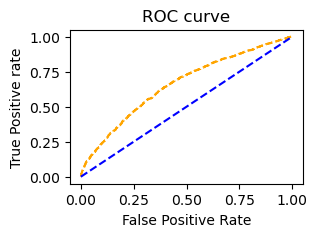

In [30]:
# ROC-AUC Curve
# plot roc curves
plt.figure(figsize=(3, 2))
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = metrics.roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.show()

#### 4aiii. Identifying the best modelling scenario
* Based on the analysis of the metrics above as detailed in the report, the XGB Model has the highest performance and this is with the DTIDRFDO dataset scenario
* However, since the DTIDRFDO is consistently low, we will assess all the scenarios using using K-fold cross validation with 10 folds
* We will then use Grid Search to choose the optimal hyperparameters for the XGBoost model

##### aiii1. XGBoost K-fold cross validation results for the different scenarios

AT scenario:
* Mean AUC - 65.337%
* Standard Deviation - 0.00893

WDT scenario:
* Mean AUC - 66.141%
* Standard Deviation - 0.01422

DTIDRF scenario:x
* Mean AUC - 65.920%
* Standard Deviation - 0.00885

DTEDRF scenario:
* Mean AUC - 66.413%
* Standard Deviation - 0.01250

In [31]:
from sklearn.model_selection import cross_val_score
aucs = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, scoring="roc_auc")
print("Accuracy: {:.3f} %".format(aucs.mean()*100))
print("Standard Deviation: {:.5f}".format(aucs.std()))

Accuracy: 66.413 %
Standard Deviation: 0.01250
